# Name: Bhone Tay Zar Kyaw 

# StudentID: 26002104465

## **Predicting Player Retention Rate of a Steam Game Based on its Reviews**

### Download Requirements : 
For neural network architecture visualization: in terminal $brew install graphviz -> $pip install pydot -> $pip install pydotplus


GloVe embeddings link and github link for text preprocessing: https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip , https://github.com/stanfordnlp/GloVe

### **Data Acquisition (Review Scraping) Using 'steamreviews' Module**

Use 'greyhack_reviews.json' as your main initial dataset. 'reviews_cleaned.json' will be created after data cleaning and feature engineering section. This 'reviews_cleaned.json' file will be used for the models.

**This section is commented out and can be skipped as dataset is already provided. Running this will produce 'review_605230.json' in data folder as a result of scraping.** 

In [1]:
# import steamreviews
# request_params = dict()
# # Reference: https://partner.steamgames.com/doc/store/localization#supported_languages
# request_params['language'] = 'all' # Setting to all languages
# # Reference: https://partner.steamgames.com/doc/store/getreviews
# request_params['review_type'] = 'all' # Including all positive and negative reviews
# request_params['purchase_type'] = 'all' # Including all purchases from Steam or received for free
# request_params['filter_offtopic_activity'] = 0 # Including review bombs

# app_id = 605230 #For Grey hack, Adjustable to different games
# review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=request_params) 

[appID = 605230] expected #reviews = 1264


Expected 1263 reviews (data points) from 'Grey Hack' 

In [2]:
# # Checking keys in each review
# print(review_dict.keys())

dict_keys(['reviews', 'query_summary', 'cursors'])


In [3]:
# first_few_keys = list(review_dict['reviews'].keys())[:5]
# print("First few keys in 'reviews':", first_few_keys)

# # Accessing the first review using the first key from the list of keys
# first_review_key = first_few_keys[4]
# first_review = review_dict['reviews'][first_review_key]

# # Printing the first review
# print(first_review)

First few keys in 'reviews': ['154402757', '154400205', '154394209', '154389145', '154388760']
{'recommendationid': '154388760', 'author': {'steamid': '76561198030883946', 'num_games_owned': 0, 'num_reviews': 21, 'playtime_forever': 46, 'playtime_last_two_weeks': 46, 'playtime_at_review': 35, 'last_played': 1703529325}, 'language': 'english', 'review': "This is an amazingly realistic hacking simulator. It has its own simulated network online, other players can hack you in-game, it starts with very good security advice, and is really fun.\n\nIt teaches you about how hacking works and provides just enough information to keep it engaging while not holding your hand. \n\nIt has its own scripting language in which you can write your own tools and scripts. It's just amazing.", 'timestamp_created': 1703528804, 'timestamp_updated': 1703528804, 'voted_up': True, 'votes_up': 3, 'votes_funny': 0, 'weighted_vote_score': '0.54356849193572998', 'comment_count': 0, 'steam_purchase': True, 'received_f

In [4]:
# import json

# filename = 'greyhack_reviews.json'

# with open(filename, 'w', encoding='utf-8') as file:
#     json.dump(review_dict, file, ensure_ascii=False, indent=4)

# print(f"Reviews saved to {filename}")

Reviews saved to greyhack_reviews.json


### **Data Cleaning and Feature Engineering** 

In [5]:
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Loading the JSON file
with open('greyhack_reviews.json') as f:
    data = json.load(f)

# Extracting reviews data
reviews_data = data['reviews']

In [6]:
# Flattening the nested data
flattened_data = []

for review_id, review in reviews_data.items():
    # Flattening the top-level attributes
    flattened_review = review.copy()

    # Extracting and adding author details to the flattened_review
    author_data = review['author']
    for key, value in author_data.items():
        flattened_review['author_' + key] = value

    # Add the flattened review to the list
    flattened_data.append(flattened_review)

# Converting the flattened data to a DataFrame
reviews_df = pd.DataFrame(flattened_data)
reviews_df.info()

# Setting to display all columns
pd.set_option('display.max_columns', 999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   recommendationid                809 non-null    object 
 1   author                          809 non-null    object 
 2   language                        809 non-null    object 
 3   review                          809 non-null    object 
 4   timestamp_created               809 non-null    int64  
 5   timestamp_updated               809 non-null    int64  
 6   voted_up                        809 non-null    bool   
 7   votes_up                        809 non-null    int64  
 8   votes_funny                     809 non-null    int64  
 9   weighted_vote_score             809 non-null    object 
 10  comment_count                   809 non-null    int64  
 11  steam_purchase                  809 non-null    bool   
 12  received_for_free               809 

In [7]:
reviews_df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,timestamp_dev_responded,developer_response
0,154402757,"{'steamid': '76561197967650790', 'num_games_ow...",english,This game is very realistic and is super fun! ...,1703541254,1703541254,True,1,0,0,0,True,False,True,True,,76561197967650790,177,84,514,514,167,1703564483,NaN,NaN
1,154400205,"{'steamid': '76561198207537119', 'num_games_ow...",english,I've been having too much fun playing it. Keep...,1703538947,1703538947,True,1,0,0,0,True,False,True,True,,76561198207537119,94,5,154,154,154,1703538758,NaN,NaN
2,154394209,"{'steamid': '76561198244171152', 'num_games_ow...",english,"Потрясающий симулятор!\nЯ не знаю, и не мог пр...",1703533594,1703533594,True,1,0,0,0,True,False,True,True,,76561198244171152,0,1,11003,237,10983,1703536530,NaN,NaN
3,154389145,"{'steamid': '76561198043718864', 'num_games_ow...",english,"A good, and I mean good, hacking simulator for...",1703529134,1703529134,True,3,0,0.54356849193572998,0,True,False,True,True,,76561198043718864,200,11,21,21,17,1703529507,NaN,NaN
4,154388760,"{'steamid': '76561198030883946', 'num_games_ow...",english,This is an amazingly realistic hacking simulat...,1703528804,1703528804,True,3,0,0.54356849193572998,0,True,False,True,True,,76561198030883946,0,21,46,46,35,1703529325,NaN,NaN


In [8]:
# Dropping unnecessary columns
reviews_df.drop(columns=['recommendationid', 'author', 'hidden_in_steam_china', 'steam_china_location', 'author_steamid', 'timestamp_dev_responded', 'developer_response'], inplace=True )

In [9]:
# Convert timestamps to date and time
reviews_df['timestamp_created'] = pd.to_datetime(reviews_df['timestamp_created'], unit='s') # time review created
reviews_df['timestamp_updated'] = pd.to_datetime(reviews_df['timestamp_updated'], unit='s') # time review updated
reviews_df['author_last_played'] = pd.to_datetime(reviews_df['author_last_played'], unit='s') #last time user played (can be updated by running review_scrape.ipynb)

In [10]:
# Finding data points with sentiment values 
# Some rows have 'english' in language col although they belong to other language in reviews col
reviews_df['textblob_sentiment'] = reviews_df['review'].apply(lambda x: TextBlob(x).sentiment.polarity) #simple sentiment analysis

# Showing that several reviews are in 'english' language although they belong to other language in language column
# Vice versa some rows have review sentiment_scores although the reviews are in languages other than English
# Languages to test: brazilian, french, german, russian, italian, polish, spanish, turkish, ukrainian    
language_test = 'german' # Looking for exceptions
reviews_df.loc[(reviews_df['language'] == language_test ) & (reviews_df['textblob_sentiment'] > 0)]

,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment
714,german,"The game is really cool, it's like a real comp...",2023-07-28 10:49:11,2023-07-28 10:49:11,True,0,0,0,0,True,False,True,0,2,1375,0,857,2023-10-11 17:34:07,0.100000
719,german,It's a nice game. If you haven't got a basic u...,2023-07-08 14:24:49,2023-07-08 14:24:49,True,0,0,0,0,True,False,True,0,6,750,0,750,2023-07-08 14:24:09,0.066667
725,german,nice,2023-05-29 17:37:02,2023-05-29 17:37:02,True,0,0,0,0,True,False,True,177,27,547,0,149,2023-06-01 12:43:52,0.600000


Among the list of languages supported, the above list has reviews that have values in sentiment analysis. After testing each language, some reviews are in English but others are not. The misleading values include french, polish and spanish.

In [11]:
# Removing rows that do not have sentiment analysis value (Assuming these are none English)
reviews_df = reviews_df[reviews_df.textblob_sentiment != 0] 

# Removing rows that have sentiment analysis value but language of review is in other language
reviews_df = reviews_df[~reviews_df['language'].isin(['french', 'polish', 'spanish'])] 

Skewness of the forever: 11.46917641577889
Skewness of the at_review: 8.189922219517243
Skewness of the two_weeks: 8.135256426231924


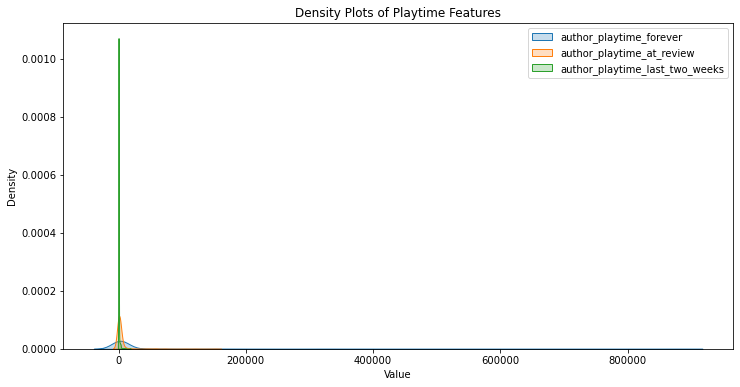

In [12]:
# Checking skewness of playtime features
forever_skewness = reviews_df['author_playtime_forever'].skew()
at_review_skewness = reviews_df['author_playtime_at_review'].skew()
two_weeks_skewness = reviews_df['author_playtime_last_two_weeks'].skew()

print(f"Skewness of the forever: {forever_skewness}")
print(f"Skewness of the at_review: {at_review_skewness}")
print(f"Skewness of the two_weeks: {two_weeks_skewness}")

col1 = 'author_playtime_forever'
col2 = 'author_playtime_at_review'
col3 = 'author_playtime_last_two_weeks'

plt.figure(figsize=(12, 6)) 

# Density Plot for each column
sns.kdeplot(reviews_df[col1], label=col1, fill=True)
sns.kdeplot(reviews_df[col2], label=col2, fill=True)
sns.kdeplot(reviews_df[col3], label=col3, fill=True)

# Adding labels and title
plt.title('Density Plots of Playtime Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Showing legend
plt.legend()

# Displaying the plot
plt.savefig('images/density_playtime.png')
plt.show()

In [13]:
# Log transformation of playtime features due to right-skewness
reviews_df['log_playtime_forever'] = np.log1p(reviews_df['author_playtime_forever'])
reviews_df['log_playtime_at_review'] = np.log1p(reviews_df['author_playtime_at_review'])
reviews_df['log_playtime_last_two_weeks'] = np.log1p(reviews_df['author_playtime_last_two_weeks'])

# Standardizing playtime features with Z-score standardization for better model performance
scaler = StandardScaler()
reviews_df['normalized_playtime_forever'] = scaler.fit_transform(reviews_df[['log_playtime_forever']]) 
reviews_df['normalized_playtime_at_review'] = scaler.fit_transform(reviews_df[['log_playtime_at_review']])
reviews_df['normalized_playtime_last_two_weeks'] = scaler.fit_transform(reviews_df[['log_playtime_last_two_weeks']])

# Creating user engagement features
reviews_df['playtime_ratio'] = reviews_df['author_playtime_at_review'] / reviews_df['author_playtime_forever']
reviews_df['days_from_last_played_time'] = (pd.Timestamp('now') - reviews_df['author_last_played']).dt.days

# Creating reviews features
reviews_df['review_length'] = reviews_df['review'].apply(len)
reviews_df['review_word_count'] = reviews_df['review'].apply(lambda x: len(x.split()))

# Creating community interaction features
reviews_df['engagement_score'] = (reviews_df['votes_up'] + reviews_df['votes_funny'] + reviews_df['comment_count'])

# Categorical feature encoding
reviews_df['voted_up'] = reviews_df['voted_up'].astype(int)
reviews_df['steam_purchase'] = reviews_df['steam_purchase'].astype(int)
reviews_df['received_for_free'] = reviews_df['received_for_free'].astype(int)
reviews_df['playtime_category'] = pd.cut(reviews_df['author_playtime_forever'], bins=[0,100,500,1000,1000000], labels=["Low", "Medium", "High", "Very High"]) # Binning lifetime playing hours of the game to playtime categories
reviews_df['reviewer_experience'] = pd.cut(reviews_df['author_num_reviews'], bins=[0,5,20,1000], labels=["Newbie", "Experienced", "Veteran"])                 # Binning num of reviews by user to across Steam to review experience categories

In [14]:
# Using VADER sentiment analysis on 'reviews' column
nltk.downloader.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Returning sentiment score of input text
def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']

reviews_df['vader_sentiment'] = reviews_df['review'].apply(get_vader_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michaelknight/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# Downloading stopwords
nltk.download('stopwords')

# Cleaning the review text from special characters for baseline models
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    return tokens

reviews_df['cleaned_review_tokens'] = reviews_df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelknight/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Setting stopwords to English
stop_words = set(stopwords.words('english'))

# Defining custom list of stopwords (adjustable)
custom_stopwords = ['game']  # Removing 'game' due to the nature of data

# Adding custom stopwords to the existing set
stop_words.update(custom_stopwords)

# Removing stopwords from reviews for baseline models
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

reviews_df['review_tokens_no_stopwords'] = reviews_df['cleaned_review_tokens'].apply(remove_stopwords)

# Joining the tokens into a single string for each row
reviews_df['cleaned_reviews_NS'] = reviews_df['review_tokens_no_stopwords'].apply(lambda x: ' '.join(x))

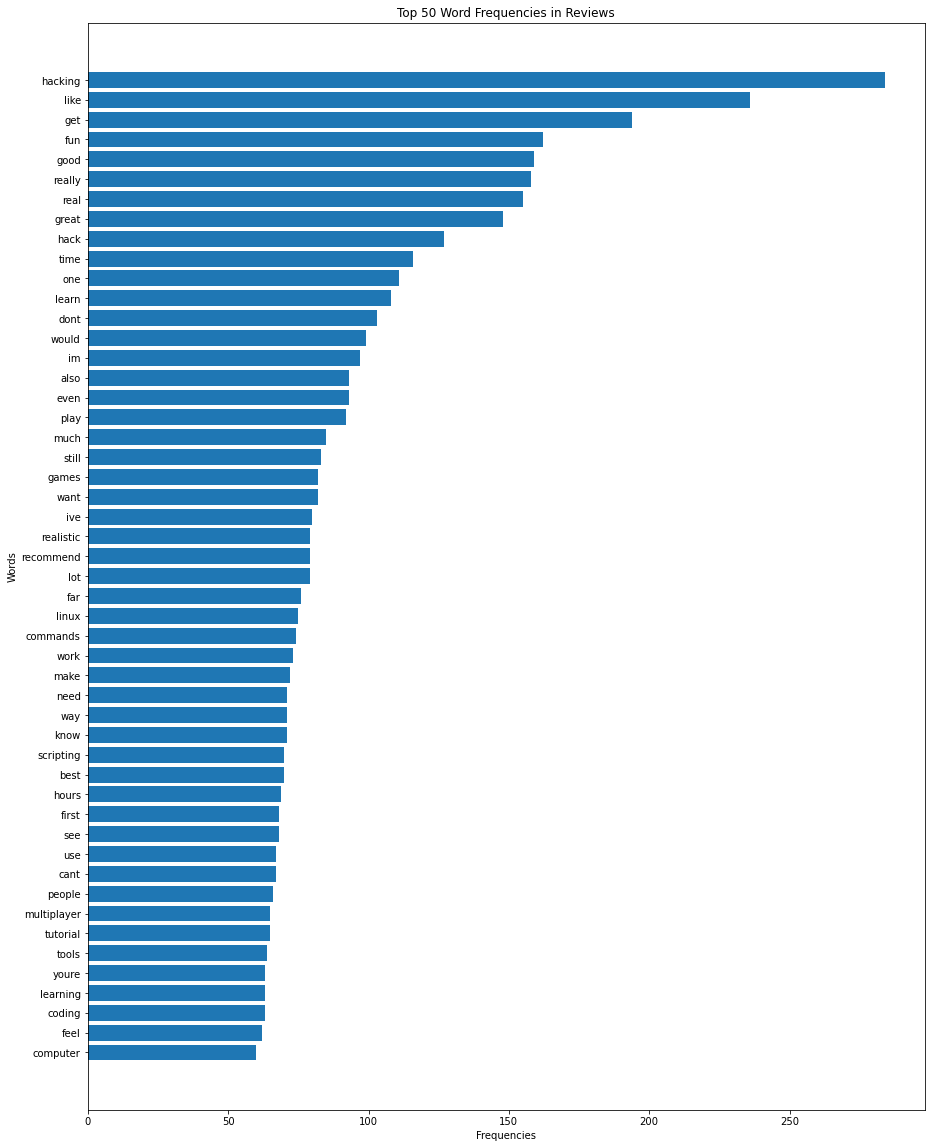

In [17]:
from collections import Counter

# Concatenating all reviews into a single string
all_reviews = ' '.join(reviews_df['cleaned_reviews_NS'])

# Creating a TextBlob object
blob = TextBlob(all_reviews)

# Counting word frequencies using Counter
word_counts = Counter(blob.words)

# Preparing data for plotting
words, counts = zip(*word_counts.most_common(50)) # Adjustable 

# Creating a bar plot for the word frequencies
plt.figure(figsize=(15, 20))
plt.barh(words, counts)
plt.xlabel('Frequencies')
plt.ylabel('Words')
plt.title('Top 50 Word Frequencies in Reviews')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.savefig('images/top50_words.png')
plt.show()

In [18]:
# Feature engineering retention score
reviews_df['retention_score'] = (
      (reviews_df['normalized_playtime_forever'] / reviews_df['normalized_playtime_forever'].max()) * 0.3 # positive indicator of user engagement with game throughout lifetime
    + (reviews_df['normalized_playtime_last_two_weeks'] / reviews_df['normalized_playtime_last_two_weeks'].max())* 0.4 # strong positive indicator of user engagement with game in recent weeks, showing strong indicator of retention
    +  reviews_df['voted_up'] * 0.15 # positive indicator of user likes the game
    +  reviews_df['steam_purchase'] * 0.05 # indicator of user more invested in the game compared to those who got it free
    + (reviews_df['textblob_sentiment'] * 0.05 / reviews_df['textblob_sentiment'].max()) # highly correlated with vader_sentiment, thus reduce the combined weight to 0.2
    + (reviews_df['vader_sentiment'] * 0.15 / reviews_df['vader_sentiment'].max()) # vader having more weight due to higher accuracy when it comes to negative sentiment compared to textblob
    - (reviews_df['days_from_last_played_time'] / reviews_df['days_from_last_played_time'].max()) * 0.1 # negative indicator of user not engaing with the game in recent period
    
)

# Rescaling the retention score from 0 to 1 
# Current retention score can be lower than 0 and higher than 1, although all features used to proxy this are normalized and weights add up to 1
scaler = MinMaxScaler()
reviews_df['retention_score_scaled'] = scaler.fit_transform(reviews_df[['retention_score']])

In [19]:
# Dropping columns that will not be used for model
reviews_df.drop(columns=['timestamp_created', 'timestamp_updated', 'author_num_games_owned', 'author_num_reviews', 'written_during_early_access', 'language'], inplace=True)

In [20]:
# Previewing the dataset after feature engineering
reviews_df.head()

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,playtime_category,reviewer_experience,vader_sentiment,cleaned_review_tokens,review_tokens_no_stopwords,cleaned_reviews_NS,retention_score,retention_score_scaled
0,This game is very realistic and is super fun! ...,1,1,0,0,0,1,0,514,514,167,2023-12-26 04:21:23,0.137000,6.244167,5.123964,6.244167,-0.641177,-0.881614,2.221707,0.324903,22,80,16,1,High,Veteran,0.8830,"[this, game, is, very, realistic, and, is, sup...","[realistic, super, fun, highly, recommend, giv...",realistic super fun highly recommend give go,0.523950,0.666361
1,I've been having too much fun playing it. Keep...,1,1,0,0,0,1,0,154,154,154,2023-12-25 21:12:38,0.500000,5.043425,5.043425,5.043425,-1.329583,-0.932331,1.716144,1.000000,22,63,13,1,Medium,Newbie,0.7906,"[ive, been, having, too, much, fun, playing, i...","[ive, much, fun, playing, keep, good, work]",ive much fun playing keep good work,0.416965,0.591340
3,"A good, and I mean good, hacking simulator for...",1,3,0,0.54356849193572998,0,1,0,21,21,17,2023-12-25 18:38:27,0.259430,3.091042,2.890372,3.091042,-2.448916,-2.288153,0.894108,0.809524,22,892,157,3,Low,Experienced,0.7269,"[a, good, and, i, mean, good, hacking, simulat...","[good, mean, good, hacking, simulator, underst...",good mean good hacking simulator understanding...,0.214457,0.449335
4,This is an amazingly realistic hacking simulat...,1,3,0,0.54356849193572998,0,1,0,46,46,35,2023-12-25 18:35:25,0.405167,3.850148,3.583519,3.850148,-2.013709,-1.851664,1.213724,0.760870,22,419,71,3,Low,Veteran,0.9191,"[this, is, an, amazingly, realistic, hacking, ...","[amazingly, realistic, hacking, simulator, sim...",amazingly realistic hacking simulator simulate...,0.320932,0.523998
6,As a security specialist of 20+ years you're d...,1,33,0,0.808946132659912109,0,1,0,410,410,181,2023-12-26 04:01:54,0.650000,6.018593,5.204007,6.018593,-0.770503,-0.831210,2.126731,0.441463,22,181,34,33,Medium,Veteran,0.8853,"[as, a, security, specialist, of, years, youre...","[security, specialist, years, youre, awesome, ...",security specialist years youre awesome job sh...,0.529042,0.669932


In [21]:
reviews_df.describe()

,voted_up,votes_up,votes_funny,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,vader_sentiment,retention_score,retention_score_scaled
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,6.760000e+02,6.760000e+02,6.760000e+02,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,0.880178,3.673077,0.880178,0.159763,0.992604,0.011834,10452.267751,270.738166,3097.747041,0.141823,7.362532,6.523973,0.967484,-1.136500e-16,1.599641e-16,7.837255e-16,0.580197,496.631657,356.153846,64.639053,4.713018,0.542379,0.247815,0.472726
std,0.324994,10.557409,6.027996,0.924358,0.085747,0.108220,47808.305757,1241.354138,11215.664731,0.263058,1.745528,1.589182,2.376816,1.000740e+00,1.000740e+00,1.000740e+00,0.326233,564.476194,597.367901,107.011276,14.372624,0.464464,0.212384,0.148931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,7.000000,-0.750000,2.708050,2.079442,0.000000,-2.668492e+00,-2.798812e+00,-4.073519e-01,0.001903,1.000000,2.000000,1.000000,0.000000,-0.989800,-0.426322,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,510.750000,0.000000,228.000000,0.001218,6.237827,5.433693,0.000000,-6.448120e-01,-6.865713e-01,-4.073519e-01,0.279016,67.000000,51.750000,10.000000,0.000000,0.380075,0.141782,0.398373
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1511.500000,0.000000,663.000000,0.126667,7.321519,6.498281,0.000000,-2.351365e-02,-1.617861e-02,-4.073519e-01,0.602709,236.500000,165.500000,30.000000,1.000000,0.709250,0.247054,0.472192
75%,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,4628.000000,0.000000,1820.500000,0.259572,8.440095,7.507402,0.000000,6.177848e-01,6.192855e-01,-4.073519e-01,0.910514,796.500000,424.250000,75.750000,3.000000,0.891000,0.343251,0.539649
max,1.000000,137.000000,115.000000,16.000000,1.000000,1.000000,878520.000000,18258.000000,152406.000000,1.000000,13.685995,11.934310,9.812413,3.625347e+00,3.407000e+00,3.724091e+00,1.000000,2224.000000,7993.000000,1460.000000,204.000000,0.999500,0.999740,1.000000


In [22]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676 entries, 0 to 808
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   review                              676 non-null    object        
 1   voted_up                            676 non-null    int64         
 2   votes_up                            676 non-null    int64         
 3   votes_funny                         676 non-null    int64         
 4   weighted_vote_score                 676 non-null    object        
 5   comment_count                       676 non-null    int64         
 6   steam_purchase                      676 non-null    int64         
 7   received_for_free                   676 non-null    int64         
 8   author_playtime_forever             676 non-null    int64         
 9   author_playtime_last_two_weeks      676 non-null    int64         
 10  author_playtime_at_review 

In [23]:
# Cleaned dataset JSON file name
cleaned_filename = 'reviews_cleaned.json'

# Saving the DataFrame to a JSON file
reviews_df.to_json(cleaned_filename, orient='records', lines=True)

print(f"DataFrame saved to {cleaned_filename}")

DataFrame saved to reviews_cleaned.json


### **Random Forest Regression Model (Baseline Model)**

In [24]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading cleaned reviews file
json_filename = 'reviews_cleaned.json'
reviews_df = pd.read_json(json_filename, orient='records', lines=True)

# Setting to display all columns
pd.set_option('display.max_columns', 999)

# Preparing TF-IDF transformer for review text
tfidf_transformer = TfidfVectorizer()

reviews_df.head()

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,playtime_category,reviewer_experience,vader_sentiment,cleaned_review_tokens,review_tokens_no_stopwords,cleaned_reviews_NS,retention_score,retention_score_scaled
0,This game is very realistic and is super fun! ...,1,1,0,0.000000,0,1,0,514,514,167,1703564483000,0.137000,6.244167,5.123964,6.244167,-0.641177,-0.881614,2.221707,0.324903,22,80,16,1,High,Veteran,0.8830,"[this, game, is, very, realistic, and, is, sup...","[realistic, super, fun, highly, recommend, giv...",realistic super fun highly recommend give go,0.523950,0.666361
1,I've been having too much fun playing it. Keep...,1,1,0,0.000000,0,1,0,154,154,154,1703538758000,0.500000,5.043425,5.043425,5.043425,-1.329583,-0.932331,1.716144,1.000000,22,63,13,1,Medium,Newbie,0.7906,"[ive, been, having, too, much, fun, playing, i...","[ive, much, fun, playing, keep, good, work]",ive much fun playing keep good work,0.416965,0.591340
2,"A good, and I mean good, hacking simulator for...",1,3,0,0.543568,0,1,0,21,21,17,1703529507000,0.259430,3.091042,2.890372,3.091042,-2.448916,-2.288153,0.894108,0.809524,22,892,157,3,Low,Experienced,0.7269,"[a, good, and, i, mean, good, hacking, simulat...","[good, mean, good, hacking, simulator, underst...",good mean good hacking simulator understanding...,0.214457,0.449335
3,This is an amazingly realistic hacking simulat...,1,3,0,0.543568,0,1,0,46,46,35,1703529325000,0.405167,3.850148,3.583519,3.850148,-2.013709,-1.851664,1.213724,0.760870,22,419,71,3,Low,Veteran,0.9191,"[this, is, an, amazingly, realistic, hacking, ...","[amazingly, realistic, hacking, simulator, sim...",amazingly realistic hacking simulator simulate...,0.320932,0.523998
4,As a security specialist of 20+ years you're d...,1,33,0,0.808946,0,1,0,410,410,181,1703563314000,0.650000,6.018593,5.204007,6.018593,-0.770503,-0.831210,2.126731,0.441463,22,181,34,33,Medium,Veteran,0.8853,"[as, a, security, specialist, of, years, youre...","[security, specialist, years, youre, awesome, ...",security specialist years youre awesome job sh...,0.529042,0.669932


In [25]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   review                              676 non-null    object 
 1   voted_up                            676 non-null    int64  
 2   votes_up                            676 non-null    int64  
 3   votes_funny                         676 non-null    int64  
 4   weighted_vote_score                 676 non-null    float64
 5   comment_count                       676 non-null    int64  
 6   steam_purchase                      676 non-null    int64  
 7   received_for_free                   676 non-null    int64  
 8   author_playtime_forever             676 non-null    int64  
 9   author_playtime_last_two_weeks      676 non-null    int64  
 10  author_playtime_at_review           676 non-null    int64  
 11  author_last_played                  676 non-n

In [26]:
# Choosing relevant features to avoid overfitting
categorical_features = ['playtime_category',  
                        'reviewer_experience']

numerical_features = [ # Playtime features
                      'normalized_playtime_forever', 
                      'normalized_playtime_last_two_weeks', 
                      'playtime_ratio', 
                      'days_from_last_played_time',
    
                       # Community Engagement features
                      'voted_up', 
                      'votes_up', 
                      'votes_funny',
                      'comment_count', 
                      'weighted_vote_score',
                      'engagement_score',
                      'textblob_sentiment', 
                      'vader_sentiment', 
                     
                       # Purchase behaviour features
                      'steam_purchase', 
                      'received_for_free', 
    
                       # Review features
                      'review_length', 
                      'review_word_count']

# Preparing transformer for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for categorical data and text data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),                                     # Handling OneHotEncoder for categorical features
        ('tfidf', tfidf_transformer, 'cleaned_reviews_NS')                                          # Applying TF-IDF vectorizer on text data
    ], remainder='passthrough')

# Defining the model
model = Pipeline(steps=[('preprocessor', preprocessor),                                             # Calling the preprocessed data
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])   # Setting RandomForestRegressor with 100 decision trees, random state for repeatibility

# Preparing target variable and features
X = reviews_df[numerical_features + categorical_features + ['cleaned_reviews_NS']]                  # Assigning all numerical, categorical and 'cleaned_review_NS' (No Stopword) as input features
y = reviews_df['retention_score_scaled']                                                            # Assigning retention score (scaled) as target label                       

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)           # Train 80%, Test 20%

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)                                                            # mean squared error for checking variance between actual and predicted scores
r2 = r2_score(y_test, y_pred)                                                                       # r-squared for checking how much the data fits well into the model

# Extracting feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Handling feature names from the preprocessor
cat_feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()   # for categorical feature names
tfidf_feature_names = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out() # for review vector names
feature_names = list(cat_feature_names) + list(tfidf_feature_names) + numerical_features

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0005698360948414258
R-squared: 0.968377224491561


A low MSE suggests high accuracy. A high R-squared suggests high effectiveness of model based on the input features.

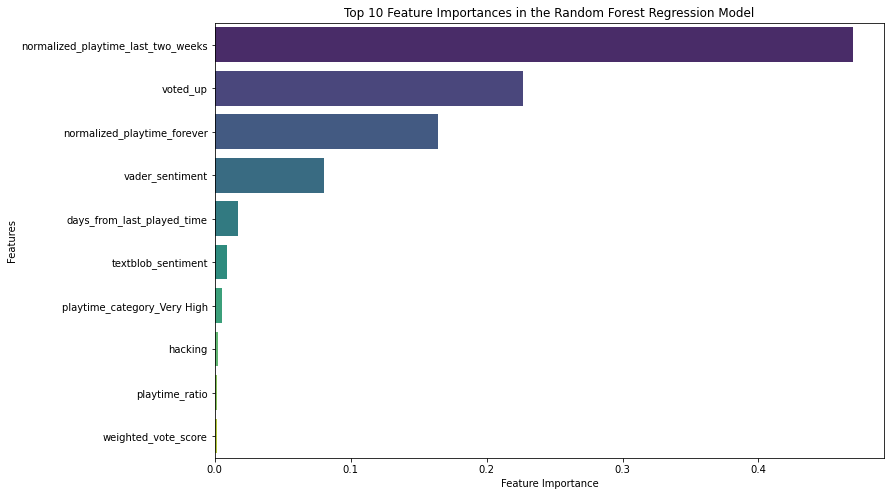

In [27]:
# Mapping feature importances to feature names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sorting the dictionary by importance
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

# Selecting the top 10 features
top_10_features = dict(list(sorted_feature_importance.items())[:10]) # adjustable

# Plotting the top 10 features
plt.figure(figsize=(12, 8))
sns.barplot(x=list(top_10_features.values()), y=list(top_10_features.keys()), palette='viridis')
plt.title('Top 10 Feature Importances in the Random Forest Regression Model')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.savefig('images/baseline_feature_importance.png')
plt.show()

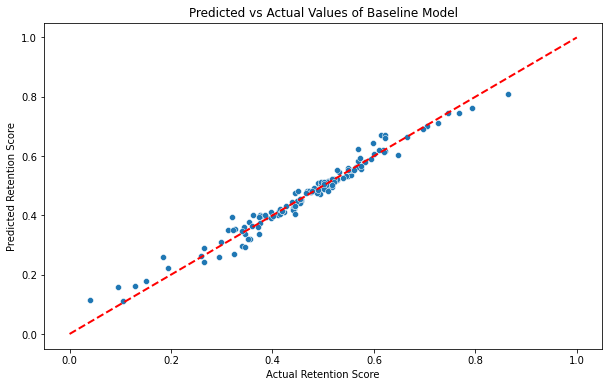

In [28]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Creating a dataFrame for visualization
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Predicted vs Actual Values of Baseline Model')
plt.xlabel('Actual Retention Score')
plt.ylabel('Predicted Retention Score')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Adding a diagonal line for reference (perfect prediction)
plt.savefig('images/baseline_actual_predict.png')
plt.show()

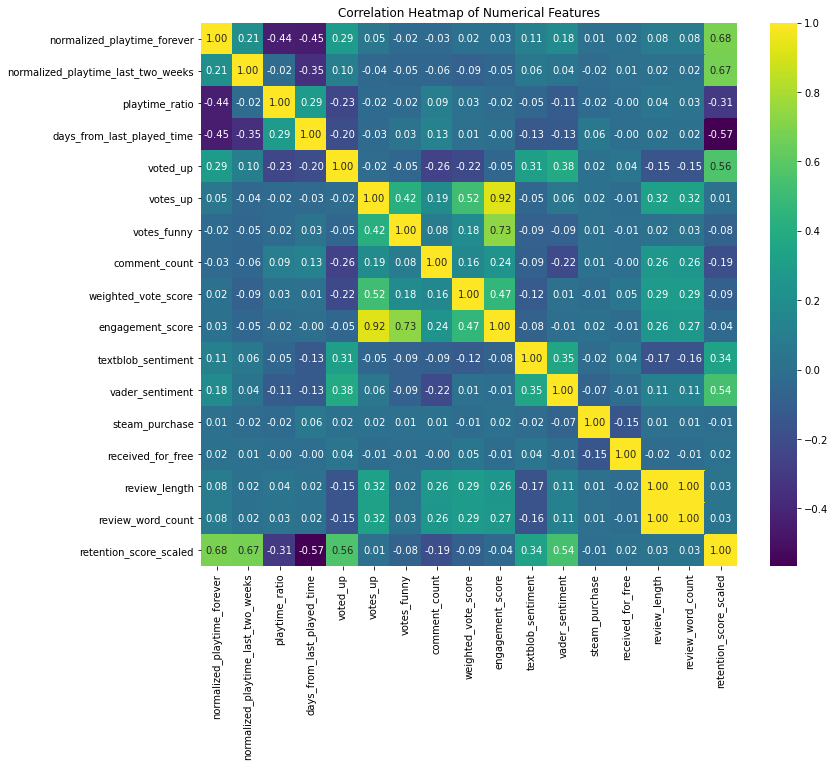

In [29]:
# Selecting only numerical features for correlation
numerical_data = reviews_df[numerical_features]

# Appending 'retention_score_scaled' to DataFrame
numerical_data_with_target = numerical_data.copy()
numerical_data_with_target['retention_score_scaled'] = reviews_df['retention_score_scaled']

# Computing the correlation matrix including the target variable
corr_matrix = numerical_data_with_target.corr()

# Creating a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('images/baseline_correlation_heatmap.png')
plt.show()

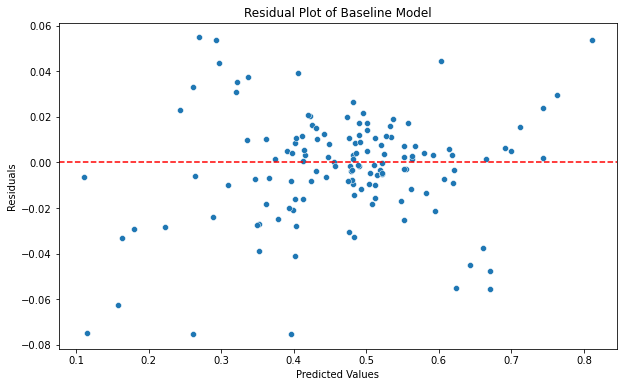

In [30]:
# Calculating residuals
residuals = y_test - y_pred

# Creating the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.title('Residual Plot of Baseline Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Adding a horizontal line at zero for reference (perfect prediction)
plt.savefig('images/baseline_residual.png')
plt.show()

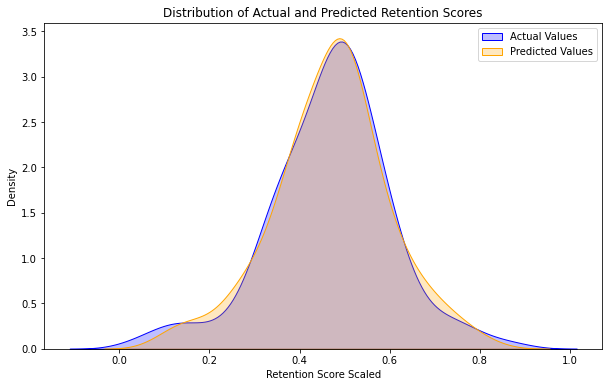

In [31]:
# Plotting the distribution of actual and predicted Retention Scores
plt.figure(figsize=(10, 6))

# Plotting the actual values
sns.kdeplot(y_test, label='Actual Values', color='blue', shade=True)

# Plotting the predicted values
sns.kdeplot(y_pred, label='Predicted Values', color='orange', shade=True)

# Adding title and labels and showing the pot
plt.title('Distribution of Actual and Predicted Retention Scores')
plt.xlabel('Retention Score Scaled')
plt.ylabel('Density')
plt.legend()
plt.savefig('images/baseline_density.png')
plt.show()

In [32]:
from sklearn.model_selection import KFold
import numpy as np

# Number of folds
n_splits = 5

# Shuffling datasets each time for cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initializing lists to store the metrics of the model for each fold
mse_scores = []
r2_scores = []

# Initialize lists to store prediction and actual scores for each fold
all_y_pred = []
all_y_test = []

# Initializing k-fold cross-validation loop (necessary to keep it consistent with original model)
for train_index, test_index in kf.split(X):
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Creating a new instance of the model pipeline for each fold
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

    # Training the model
    model.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Appending the scores
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Storing predictions and actual values
    all_y_pred.extend(y_pred)
    all_y_test.extend(y_test)

# Calculating and printing the average scores across all folds
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {average_mse}")
print(f"Average R-squared: {average_r2}")


Average Mean Squared Error: 0.0007946963693583987
Average R-squared: 0.9641432366019554


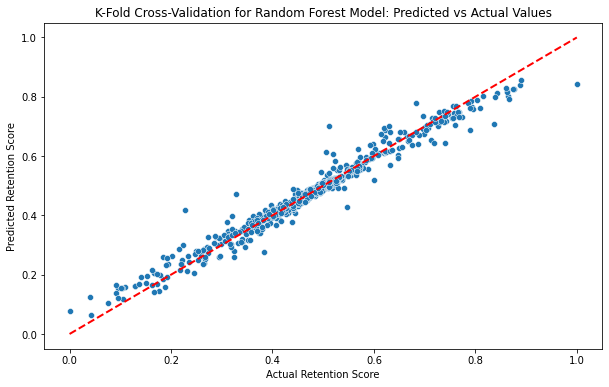

In [33]:
# Plotting Predicted vs Actual for K-Fold Cross-Validation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_y_test, y=all_y_pred)
plt.title('K-Fold Cross-Validation for Random Forest Model: Predicted vs Actual Values')
plt.xlabel('Actual Retention Score')
plt.ylabel('Predicted Retention Score')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for reference
plt.savefig('images/baseline_kf_actual_predict.png')
plt.show()

### **Hybrid Neural Network (Advanced Model)**

In [34]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

json_filename = 'reviews_cleaned.json'
reviews_df = pd.read_json(json_filename, orient='records', lines=True)
pd.set_option('display.max_columns', 999)
reviews_df.head()

,review,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,playtime_category,reviewer_experience,vader_sentiment,cleaned_review_tokens,review_tokens_no_stopwords,cleaned_reviews_NS,retention_score,retention_score_scaled
0,This game is very realistic and is super fun! ...,1,1,0,0.000000,0,1,0,514,514,167,1703564483000,0.137000,6.244167,5.123964,6.244167,-0.641177,-0.881614,2.221707,0.324903,22,80,16,1,High,Veteran,0.8830,"[this, game, is, very, realistic, and, is, sup...","[realistic, super, fun, highly, recommend, giv...",realistic super fun highly recommend give go,0.523950,0.666361
1,I've been having too much fun playing it. Keep...,1,1,0,0.000000,0,1,0,154,154,154,1703538758000,0.500000,5.043425,5.043425,5.043425,-1.329583,-0.932331,1.716144,1.000000,22,63,13,1,Medium,Newbie,0.7906,"[ive, been, having, too, much, fun, playing, i...","[ive, much, fun, playing, keep, good, work]",ive much fun playing keep good work,0.416965,0.591340
2,"A good, and I mean good, hacking simulator for...",1,3,0,0.543568,0,1,0,21,21,17,1703529507000,0.259430,3.091042,2.890372,3.091042,-2.448916,-2.288153,0.894108,0.809524,22,892,157,3,Low,Experienced,0.7269,"[a, good, and, i, mean, good, hacking, simulat...","[good, mean, good, hacking, simulator, underst...",good mean good hacking simulator understanding...,0.214457,0.449335
3,This is an amazingly realistic hacking simulat...,1,3,0,0.543568,0,1,0,46,46,35,1703529325000,0.405167,3.850148,3.583519,3.850148,-2.013709,-1.851664,1.213724,0.760870,22,419,71,3,Low,Veteran,0.9191,"[this, is, an, amazingly, realistic, hacking, ...","[amazingly, realistic, hacking, simulator, sim...",amazingly realistic hacking simulator simulate...,0.320932,0.523998
4,As a security specialist of 20+ years you're d...,1,33,0,0.808946,0,1,0,410,410,181,1703563314000,0.650000,6.018593,5.204007,6.018593,-0.770503,-0.831210,2.126731,0.441463,22,181,34,33,Medium,Veteran,0.8853,"[as, a, security, specialist, of, years, youre...","[security, specialist, years, youre, awesome, ...",security specialist years youre awesome job sh...,0.529042,0.669932


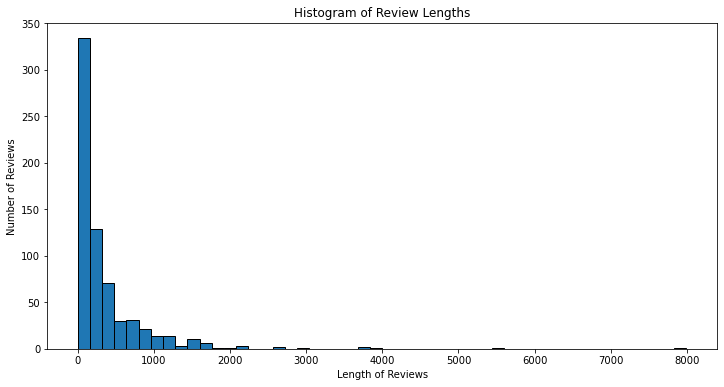

In [35]:
# Plotting the histogram of review lengths
plt.figure(figsize=(12, 6))
plt.hist(reviews_df['review_length'], bins=50, edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.savefig('images/review_length_hist.png')
plt.show()

In [36]:
# Processing text and preparing word embeddings using a pre-trained GloVe model
from tensorflow.keras.preprocessing.text import Tokenizer

# Initializing and fit the tokenizer
tokenizer = Tokenizer(num_words=5000)        # Top 5000 words based on frequency
tokenizer.fit_on_texts(reviews_df['review']) # Converting review into a sequence of integers

# Loading GloVe embeddings
# Provided link here to download GloVe embeddings: https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip
embeddings_index = {}
with open('glove/glove.twitter.27B.200d.txt', encoding='utf8') as f: # Using twitter text data with 200 dimesions
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Preparing the embedding matrix
embedding_dim = 200  #  Matching the dimension of the GloVe embeddings file 
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Text Preprocessing
max_review_length = 2000  # Capture most reviews (from histogram of reviews)
review_sequences = tokenizer.texts_to_sequences(reviews_df['review'])
review_padded = pad_sequences(review_sequences, maxlen=max_review_length)

# Preparing One Hot encoder for categorical data and fit them into numerical values
encoder = OneHotEncoder(sparse=False)
categorical_data = encoder.fit_transform(reviews_df[['playtime_category', 'reviewer_experience']])

# Scaling numerical features
scaler = StandardScaler()
numerical_data = scaler.fit_transform(reviews_df[[# Playtime features
                                                  'normalized_playtime_forever', 
                                                  'normalized_playtime_last_two_weeks', 
                                                  'playtime_ratio', 
                                                  'days_from_last_played_time',
    
                                                  # Community Engagement features
                                                  'voted_up', 
                                                  'votes_up', 
                                                  'votes_funny',
                                                  'comment_count', 
                                                  'weighted_vote_score',
                                                  'engagement_score',
                                                  'textblob_sentiment', 
                                                  'vader_sentiment', 
    
                                                  # Purchase behaviour features
                                                  'steam_purchase', 
                                                  'received_for_free', 
    
                                                  # Review features
                                                  'review_length', 
                                                  'review_word_count'
    ]])

# Preparing the input features and target label 
X_combined = np.hstack((categorical_data, numerical_data))
y = reviews_df['retention_score_scaled'].values

# Splitting the data with 80% train and 20% test
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_train_text, X_test_text = train_test_split(review_padded, test_size=0.2, random_state=42)

# Preparing input layers for review text and specific combined features
input_text = Input(shape=(max_review_length,))
input_combined = Input(shape=(X_train_combined.shape[1],))

# Branch for processing review text
text_branch = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_text) # Embedding layer for input text to vectors
text_branch = LSTM(128)(text_branch) # Long Short-Term Memory (LSTM) layer with 128 units for text sequences, Adjustable Hyperparameter
text_branch = Flatten()(text_branch) # Flattening the output into a 1D array

# Branch for processing combined data (categorical, numerical)
combined_branch = Dense(128, activation='relu')(input_combined) # Creating a densely connected Neural Network layer with 128 units
combined_branch = Dropout(0.3)(combined_branch)  # Setting 30% of neurons' output to 0 to avoid overfitting, Adjustable Hyperparameter, forces the NN to learn more robust features

# Combine the previous branches 
concat = Concatenate()([text_branch, combined_branch])
dense = Dense(128, activation='relu')(concat) # Creating a densely connected Neural Network layer with 128 units
dense = Dropout(0.3)(dense)  #  Avoiding overfitting ,Adjustable Hyperparameter
output = Dense(1, activation='sigmoid')(dense)  # Sigmoid activation for output (retention_rate_scaled) as it is binary classification

# Compile the model
optimizer = Adam(learning_rate=0.001)  # To minimize loss function, Adjustable hyperparameter
model = Model(inputs=[input_text, input_combined], outputs=output) # Constructing the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # Compiling the model, loss function - MSE, evaluation metrics - MAE

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5) # Stopping training process if loss does not improve for 5 epochs, Adjustable Hyperparameter
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True) # Saving the best model everytime the loss improves, for model callback

# Training the model 
history = model.fit([X_train_text, X_train_combined], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Loading and evaluating the best model
best_model = load_model('best_model.h5')
y_pred = best_model.predict([X_test_text, X_test_combined])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
14/14 [==============================] - 26s 2s/step - loss: 0.0220 - mae: 0.1065 - val_loss: 0.0024 - val_mae: 0.0389
Epoch 2/20
14/14 [==============================] - 22s 2s/step - loss: 0.0064 - mae: 0.0610 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 3/20
14/14 [==============================] - 22s 2s/step - loss: 0.0043 - mae: 0.0487 - val_loss: 0.0018 - val_mae: 0.0273
Epoch 4/20
14/14 [==============================] - 23s 2s/step - loss: 0.0036 - mae: 0.0434 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 5/20
14/14 [==============================] - 22s 2s/step - loss: 0.0032 - mae: 0.0420 - val_loss: 7.3673e-04 - val_mae: 0.0207
Epoch 6/20
14/14 [==============================] - 22s 2s/step - loss: 0.0027 - mae: 0.0378 - val_loss: 7.0258e-04 - val_mae: 0.0190
Epoch 7/20
14/14 [==============================] - 22s 2s/step - loss: 0.0025 - mae: 0.0365 - val_loss: 9.4838e-04 - val_mae: 0.0213
Epoch 8/20
14/14 [==============================] - 22s 2s/step - loss: 0.0025

5/5 [==============================] - 2s 415ms/step


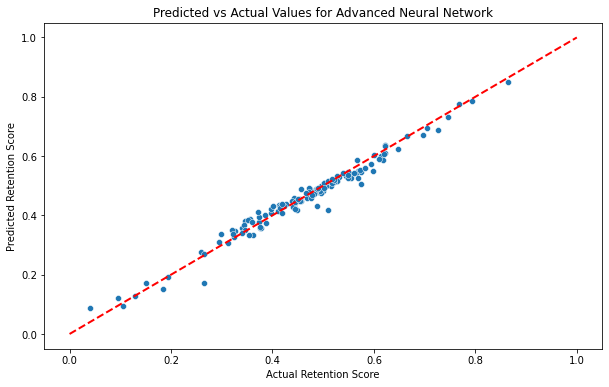

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting on the test set
y_pred = best_model.predict([X_test_text, X_test_combined]).flatten()

# Creating a DataFrame for visualization
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results_df)
plt.title('Predicted vs Actual Values for Advanced Neural Network')
plt.xlabel('Actual Retention Score')
plt.ylabel('Predicted Retention Score')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for reference (Perfect Prediction)
plt.savefig('images/advanced_actual_predict.png')
plt.show()

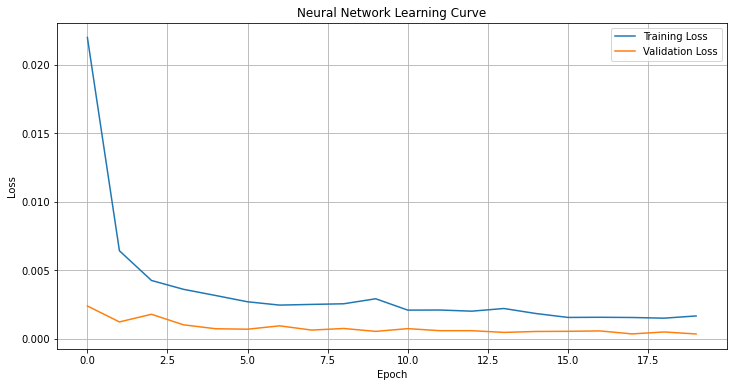

In [39]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('images/advanced_lr.png')
plt.show()


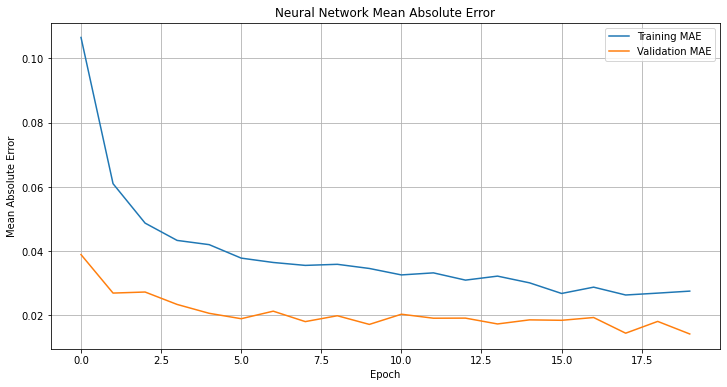

In [40]:
# Plotting Mean Absolute Error (MAE)
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Neural Network Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('images/advanced_mae.png')
plt.show()

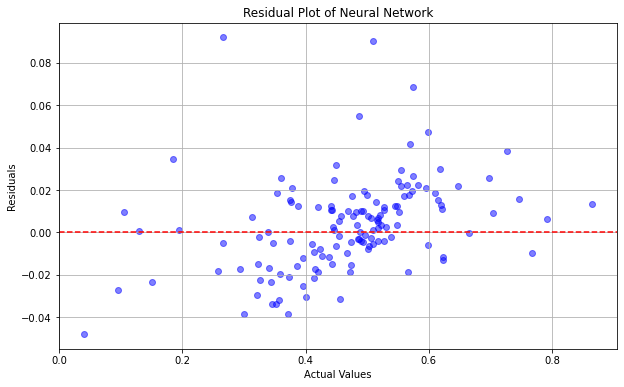

In [41]:
# Calculating residuals
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10, 6))

# Creating a scatter plot of actual vs. residuals
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.title('Residual Plot of Neural Network')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Adds a horizontal line at zero for reference
plt.grid(True)

# Show the plot
plt.savefig('images/advanced_residual.png')
plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2000, 200)    938000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          168448      ['embedding[0][0]']              
                                                                                              

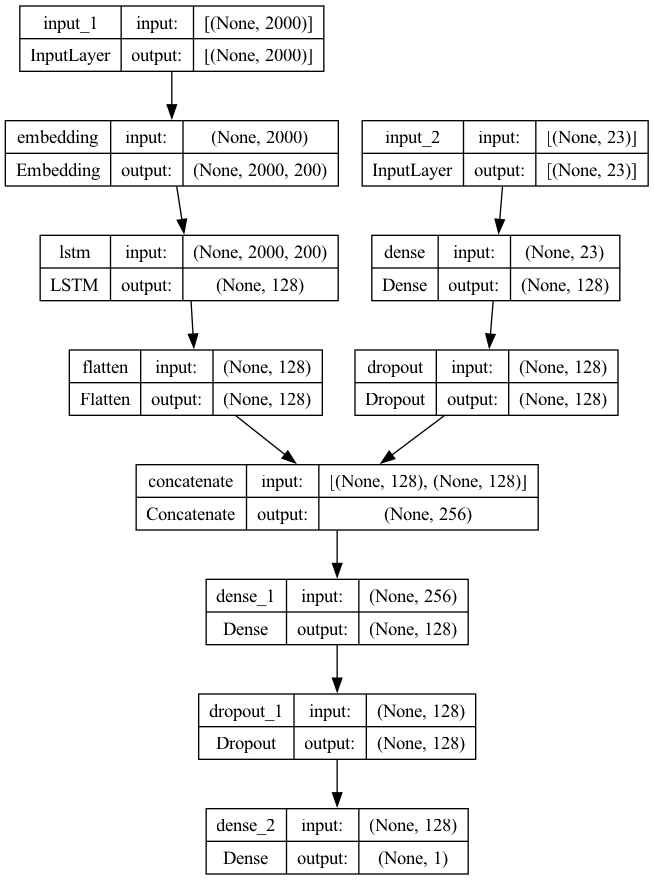

In [42]:
best_model.summary()
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Ploting the model
plot_model(best_model, to_file='images/best_model_visualization.png', show_shapes=True, show_layer_names=True)

In [43]:
# Performing K-Fold Cross-Validation on Neural Network Model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_combined):
    X_train_combined, X_test_combined = X_combined[train_index], X_combined[test_index]
    X_train_text, X_test_text = review_padded[train_index], review_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Preparing input layers for review text and specific combined features
    input_text = Input(shape=(max_review_length,))
    input_combined = Input(shape=(X_train_combined.shape[1],))

    # Branch for processing review text
    text_branch = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_text) # Embedding layer for input text to vectors
    text_branch = LSTM(128)(text_branch) # Long Short-Term Memory (LSTM) layer with 128 units for text sequences, Adjustable Hyperparameter
    text_branch = Flatten()(text_branch) # Flattening the output into a 1D array

    # Branch for processing combined data (categorical, numerical)
    combined_branch = Dense(128, activation='relu')(input_combined) # Creating a densely connected Neural Network layer with 128 units
    combined_branch = Dropout(0.3)(combined_branch)  # Setting 30% of neurons' output to 0 to avoid overfitting, Adjustable Hyperparameter, forces the NN to learn more robust features

    # Combine the previous branches 
    concat = Concatenate()([text_branch, combined_branch])
    dense = Dense(128, activation='relu')(concat) # Creating a densely connected Neural Network layer with 128 units
    dense = Dropout(0.3)(dense)  #  Avoiding overfitting ,Adjustable Hyperparameter
    output = Dense(1, activation='sigmoid')(dense)  # Sigmoid activation for output (retention_rate_scaled) as it is binary classification

    # Compile the model
    optimizer = Adam(learning_rate=0.001)  # To minimize loss function, Adjustable hyperparameter
    model = Model(inputs=[input_text, input_combined], outputs=output) # Constructing the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) # Compiling the model, loss function - MSE, evaluation metrics - MAE

    # Early Stopping and Model Checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=5) # Stopping training process if loss does not improve for 5 epochs, Adjustable Hyperparameter
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True) # Saving the best model everytime the loss improves, for model callback

    # Training the model 
    history = model.fit([X_train_text, X_train_combined], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

    # Loading and evaluating the best model
    best_model = load_model('best_model.h5')
    y_pred = best_model.predict([X_test_text, X_test_combined])
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)
    

# Calculate average scores
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f"Average Mean Squared Error: {average_mse}")
print(f"Average R-squared: {average_r2}")

Epoch 1/20
14/14 [==============================] - 24s 1s/step - loss: 0.0129 - mae: 0.0815 - val_loss: 0.0051 - val_mae: 0.0538
Epoch 2/20
14/14 [==============================] - 20s 1s/step - loss: 0.0051 - mae: 0.0543 - val_loss: 0.0032 - val_mae: 0.0463
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 0.0044 - mae: 0.0482 - val_loss: 0.0034 - val_mae: 0.0486
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 0.0029 - mae: 0.0370 - val_loss: 0.0047 - val_mae: 0.0533
Epoch 5/20
14/14 [==============================] - 19s 1s/step - loss: 0.0026 - mae: 0.0339 - val_loss: 0.0020 - val_mae: 0.0351
Epoch 6/20
14/14 [==============================] - 20s 1s/step - loss: 0.0028 - mae: 0.0341 - val_loss: 0.0031 - val_mae: 0.0419
Epoch 7/20
14/14 [==============================] - 19s 1s/step - loss: 0.0016 - mae: 0.0302 - val_loss: 0.0039 - val_mae: 0.0467
Epoch 8/20
14/14 [==============================] - 19s 1s/step - loss: 0.0020 - mae: 0.02

14/14 [==============================] - 18s 1s/step - loss: 0.0048 - mae: 0.0524 - val_loss: 0.0051 - val_mae: 0.0594
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 0.0036 - mae: 0.0451 - val_loss: 0.0049 - val_mae: 0.0572
Epoch 4/20
14/14 [==============================] - 19s 1s/step - loss: 0.0034 - mae: 0.0394 - val_loss: 0.0030 - val_mae: 0.0432
Epoch 5/20
14/14 [==============================] - 18s 1s/step - loss: 0.0026 - mae: 0.0355 - val_loss: 0.0019 - val_mae: 0.0347
Epoch 6/20
14/14 [==============================] - 18s 1s/step - loss: 0.0020 - mae: 0.0314 - val_loss: 0.0027 - val_mae: 0.0395
Epoch 7/20
14/14 [==============================] - 18s 1s/step - loss: 0.0026 - mae: 0.0327 - val_loss: 0.0021 - val_mae: 0.0348
Epoch 8/20
14/14 [==============================] - 18s 1s/step - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 9/20
14/14 [==============================] - 18s 1s/step - loss: 0.0019 - mae: 0.0294 - val_lo